# <font color='Orange'>Julia packages installed in the NCI-geophysics Singularity image</font>

In [1]:
]st

Status `/opt/julia/environments/v1.8/Project.toml`
  [c3fe647b] AbstractAlgebra v0.30.2
⌅ [c9ce4bd3] ArchGDAL v0.7.4
  [6e4b80f9] BenchmarkTools v1.3.2
  [179af706] CFTime v0.1.2
⌅ [052768ef] CUDA v3.13.1
⌃ [13f3f980] CairoMakie v0.6.6
  [d360d2e6] ChainRulesCore v1.16.0
  [5ae59095] Colors v0.12.10
  [150eb455] CoordinateTransformations v0.6.3
⌃ [a93c6f00] DataFrames v1.3.6
  [31a5f54b] Debugger v0.7.8
  [06ed14b1] Devito v0.10.2
  [aaf54ef3] DistributedArrays v0.6.6
  [31c24e10] Distributions v0.25.90
  [7c1d4256] DynamicPolynomials v0.4.6
  [902c3f28] Elemental v0.6.0
  [7a1cc6ca] FFTW v1.6.0
⌃ [587475ba] Flux v0.13.13
  [069b7b12] FunctionWrappers v1.1.3
⌃ [a8dd9ffe] GADM v0.2.4
  [add2ef01] GDAL v1.5.1
  [5752ebe1] GMT v0.44.8
⌃ [2fb1d81b] GeoArrays v0.7.5
  [9b6fcbb8] GeoData v0.6.1
⌃ [62cb38b5] GeoDataFrames v0.2.0
  [ddc7317b] GeoDatasets v0.1.7
⌅ [68eda718] GeoFormatTypes v0.3.0
⌅ [cf35fbd7] GeoInterface v0.5.7
⌅ [61d90e0f] GeoJSON v0.5.1
⌃ [db073c08] GeoMakie v0.2.2
⌃ [dcc97b

# <font color='Orange'>NCDatasets and PyPlot</font>   

In [2]:
using NCDatasets, PyPlot

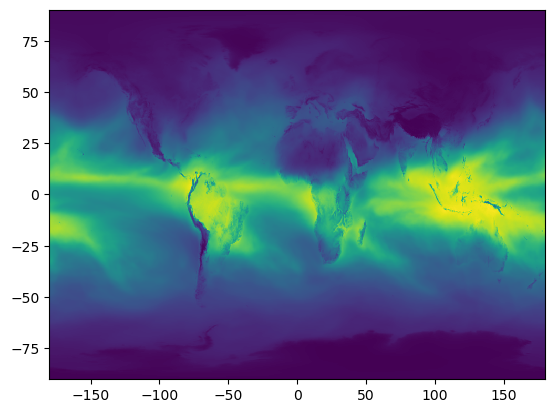

In [3]:
fn = "/g/data/rt52/era5/single-levels/monthly-averaged/tcwv/2010/tcwv_era5_moda_sfc_20101201-20101231.nc"
ds = NCDataset(fn);
lon = ds["longitude"][:];
lat = ds["latitude"][:];
pwv = ds["tcwv"][:,:,1]*1;

pcolormesh(lon,lat,pwv')

close(ds);

# <font color='Orange'>HiQGA.jl</font>   

In [4]:
pushfirst!(DEPOT_PATH, "/opt/julia")
pushfirst!(DEPOT_PATH, "~/.julia")
using Logging
Logging.disable_logging(Logging.Warn)

LogLevel(1001)

## Setup the Simulation

In [5]:
using HiQGA.transD_GP, PyPlot, Random, Distributed

In [6]:
zfixed   = [-1e5]
ρfixed   = [1e12]
nmax = 200;

zstart = 0.
extendfrac1, dz1, n1 = 1.06, 1.15, 50
zall, znall, zboundaries = transD_GP.setupz(zstart, extendfrac1, dz=dz1, n=n1, showplot=false, forextension=true)
extendfrac2, dz2, n2 = 1.5, nothing, 15
zall, znall, zboundaries = transD_GP.zcontinue(;zall=zall, znall=znall, zboundaries=zboundaries, extendfrac=extendfrac2, dz=dz2, n=n2, showplot=false)
z, ρ, nfixed = transD_GP.makezρ(zboundaries; zfixed=zfixed, ρfixed=ρfixed);

In [7]:
ρ[(z.>=zstart) .& (z.<20)] .= 800.
ρ[(z.>=20) .&(z.<40)] .= 100
ρ[(z.>=40) .&(z.<50)] .= 10
ρ[(z.>=50) .&(z.<70)] .= 1
ρ[(z.>=70) .&(z.<100)] .= 20
ρ[(z.>=100) .&(z.<120)] .= 80
ρ[(z.>=120) .&(z.<140)] .= 2
ρ[(z.>=140) .&(z.<250)] .= 100.
ρ[(z.>=250) .&(z.<270)] .= 100.
ρ[(z.>=270) .&(z.<600)] .= 150
ρ[(z.>=600) .&(z.<800)] .= 2
ρ[(z.>=800) .&(z.<5000)] .= 500
ρ[z.>=5000] .= 700;

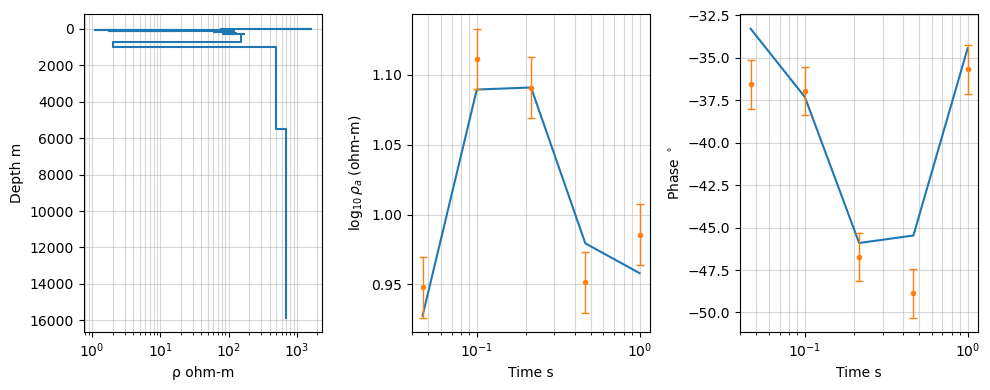

In [8]:
Random.seed!(11)
ρ[1:50] = 10 .^(0.1*randn(length(ρ[1:50])) + log10.(ρ[1:50]));
T = 10 .^range(-3, 0, length=10)[6:10]
F = transD_GP.MT1DInversion.create_synthetic(ρ =  ρ[2:end], zboundaries = zboundaries, freqs = 1 ./T, rseed=125, showplot=true, noisefrac=0.05, logscaledepth=false);
ρlow, ρhigh = -0.5*ones(size(zall)), zall*0.00005 .+ 3.15
Δ = ρhigh - ρlow
F = transD_GP.MT1DInversion.makestretchop(F, ρlow=ρlow, Δ=Δ);

In [9]:
F.stretch = false
fileprefix = "MT_only_useful_stretchis$(string(F.stretch))_"
K = transD_GP.GP.OrstUhn()
nmin, nmax = 2, 40
fbounds = F.stretch ? [0 1.] : [-0.5 4]
sdev_pos = [0.05abs(diff([extrema(znall)...])[1])]
sdev_prop = 0.07*diff(fbounds, dims=2)[:]
demean = false
sdev_dc = 0.008*diff(fbounds, dims=2)[:]
sampledc = true
xall = permutedims(collect(znall))
xbounds = permutedims([extrema(znall)...])
λ, δ = [2], F.stretch ? 0.03 : 0.1 
Random.seed!(12)
opt = transD_GP.OptionsStat(debug = false,
                        nmin = nmin,
                        nmax = nmax,
                        xbounds = xbounds,
                        fbounds = fbounds,
                        fdataname = fileprefix,
                        xall = xall,
                        λ = λ,
                        δ = δ,
                        sdev_prop = sdev_prop,
                        sdev_pos = sdev_pos,
                        save_freq = 50,
                        demean = demean,
                        sampledc = sampledc,
                        sdev_dc = sdev_dc,
                        quasimultid = false,
                        K = K
                        );

### Configure Run in Parallel

In [10]:
# increse nsamples to make the simulation result more accurate; use 10K to limit the runtime to ~80 sec
nsamples, nchains, nchainsatone = 10001, 14, 1
Tmax = 2.50
addprocs(nchains)
@info "workers are $(workers())"
@everywhere using Logging
@everywhere Logging.disable_logging(Logging.Warn)
println("workers are $(workers())")

workers are [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [11]:
@everywhere pushfirst!(DEPOT_PATH,"～/.julia")
@everywhere using Distributed
@everywhere using HiQGA.transD_GP

In [12]:
; bash -c "rm misfit*.bin"

In [13]:
@time transD_GP.main(opt, F, Tmax=Tmax, nsamples=nsamples, nchains=nchains, nchainsatone=nchainsatone)

 53.030837 seconds (27.47 M allocations: 2.705 GiB, 0.85% gc time, 7.46% compilation time: 1% of which was recompilation)


In [14]:
## close the worker pool
t = rmprocs(workers()...)
wait(t)
println("workers are $(workers())")

workers are [1]


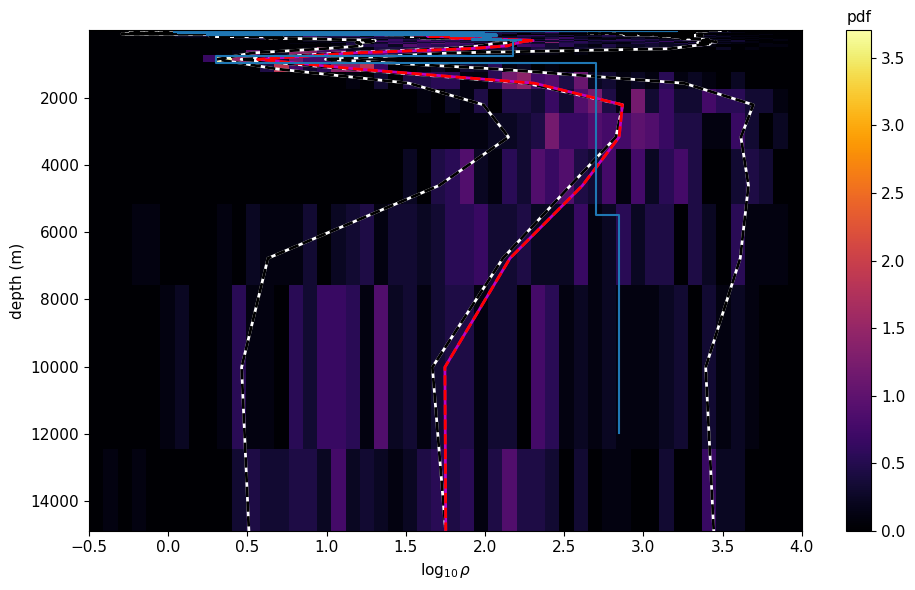

In [15]:
opt.xall[:] .= zall
transD_GP.plot_posterior(F, opt, burninfrac=0.5, figsize=(10,6), qp1=0.05, qp2=0.95, nbins=50, fsize=11)
ax = gcf().axes[1]
ax.step(log10.(ρ[2:end]), z[2:end])
if F.stretch
    transD_GP.MT1DInversion.plotpriorenv(F, ax=ax, lc = "r", plotlinear=false)
end

# <font color='Orange'>JUDI</font>   

In [16]:
using JUDI, PyPlot, LinearAlgebra

#### Grid

In [17]:
shape = (201, 201) # Number of gridpoints nx, nz
spacing = (10.0, 10.0) # #n meters here
origin = (0.0, 0.0) # In meters as well

(0.0, 0.0)

#### Physical object

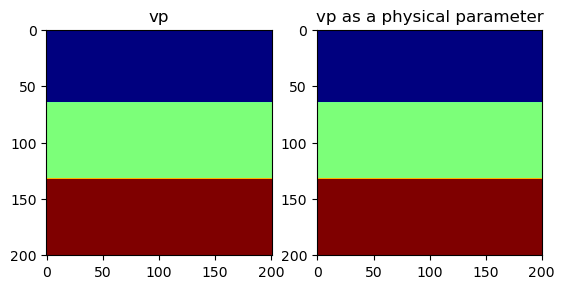

PyObject Text(0.5, 1.0, 'vp as a physical parameter')

In [18]:
# Define the velocity (in km/sec=m/ms)
vp = 1.5f0 * ones(Float32, shape)
vp[:, 66:end] .= 2.0f0
vp[:, 134:end] .= 2.5f0
# Create a physical parameter
VP = PhysicalParameter(vp, spacing, origin);

figure()
subplot(121)
imshow(vp', cmap="jet")
title("vp")
subplot(122)
imshow(VP', cmap="jet")
title("vp as a physical parameter")

#### Model

In [19]:
model = Model(shape, spacing, origin, 1f0./vp.^2f0)

Model (n=(201, 201), d=(10.0f0, 10.0f0), o=(0.0f0, 0.0f0)) with parameters [:m]

#### Acquisition Geometry

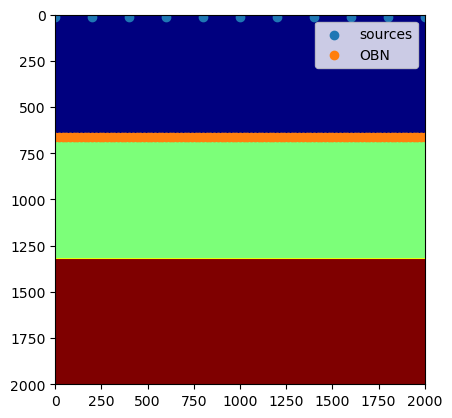

PyObject <matplotlib.legend.Legend object at 0x149bf7f1d790>

In [20]:
# Sources position
nsrc = 11
xsrc = range(0f0, (shape[1] -1)*spacing[1], length=nsrc)
ysrc = 0f0 .* xsrc # this a 2D case so we set y to zero
zsrc = 12.5f0*ones(Float32, nsrc);

xsrc, ysrc, zsrc = convertToCell.([xsrc, ysrc, zsrc]);

# OBN position
nrec = 101
xrec = range(0f0, (shape[1] -1)*spacing[1], length=nrec)
yrec = 0f0 # this a 2D case so we set y to zero. This can be a single number for receivers
zrec = (66*spacing[1])*ones(Float32, nrec);

record_time = 4000f0 # Recording time in ms (since we have m/ms for the velocity)
sampling_rate = 4f0; # Let's use a standard 4ms sampling rate

src_geom = Geometry(xsrc, ysrc, zsrc; dt=sampling_rate, t=record_time)
# For the receiver geometry, we specify the number of source to tell JUDI to use the same receiver position for all sources
rec_geom = Geometry(xrec, yrec, zrec, dt=sampling_rate, t=record_time, nsrc=nsrc);

figure();
imshow(vp', cmap="jet", extent=[0, (shape[1]-1)*spacing[1], (shape[2]-1)*spacing[2], 0])
scatter(xsrc, zsrc, label=:sources)
scatter(xrec, zrec, label="OBN")
legend()

#### Source wavelet

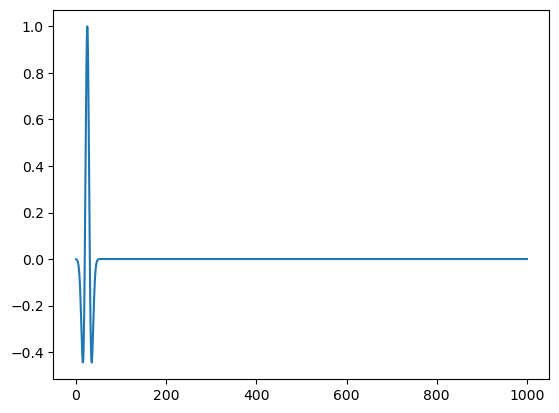

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x149bf7eaaca0>

In [21]:
f0 = 0.010 # Since we use ms, the frequency is in KHz
wavelet = ricker_wavelet(record_time, sampling_rate, f0);
plot(wavelet)

#### judiVector

In [22]:
q = judiVector(src_geom, wavelet)

judiVector{Float32, Matrix{Float32}} with 11 sources


#### Linear operator

In [23]:
Pr = judiProjection(rec_geom) # receiver interpolation
Ps = judiProjection(src_geom) # Source interpolation
Ainv = judiModeling(model) # Inverse of the disrete ewave equation.

JUDI forward{Float32} propagator (x * z * time) -> (x * z * time)

In [24]:
#### Seismic data

In [25]:
d_obs = Pr * Ainv * Ps' * q

Building forward operator
/opt/conda/envs/geophys/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/envs/geophys/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Operator `forward` ran in 0.37 s
Operator `forward` ran in 0.36 s
Operator `forward` ran in 0.36 s
Operator `forward` ran in 0.36 s
Operator `forward` ran in 0.36 s
Operator `forward` ran in 0.36 s
Operator `forward` ran in 0.36 s
Operator `forward` ran in 0.36 s
Operator `forward` ran in 0.36 s
Operator `forward` ran in 1.02 s
Operator `forward` ran in 1.04 s


judiVector{Float32, Matrix{Float32}} with 11 sources


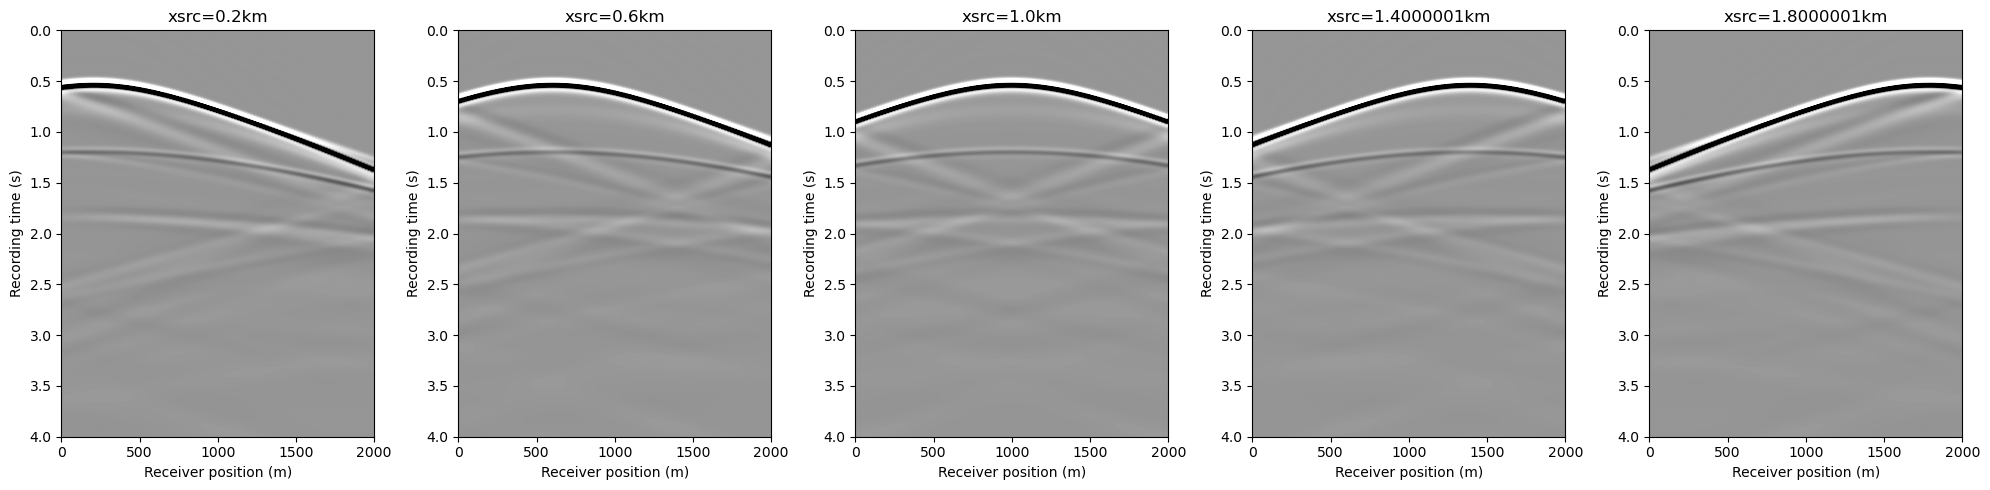

In [26]:
data_extent = [xrec[1], xrec[end], 1f-3*record_time, 0]
figure(figsize=(20, 5))
for i=1:5
    subplot(1, 5, i)
    imshow(d_obs.data[2*i], vmin=-1, vmax=1, cmap="Greys", extent=data_extent, aspect="auto")
    xlabel("Receiver position (m)")
    ylabel("Recording time (s)")
    title("xsrc=$(1f-3xsrc[2*i][1])km")
end
tight_layout()

## FWI with Quasi-Newton methods from the NLopt library

In [27]:
using SegyIO, HDF5, PyPlot, JUDI, NLopt, Random, LinearAlgebra, Printf

#### Load FWI starting model from HDF5 model file and set up the JUDI model structure:

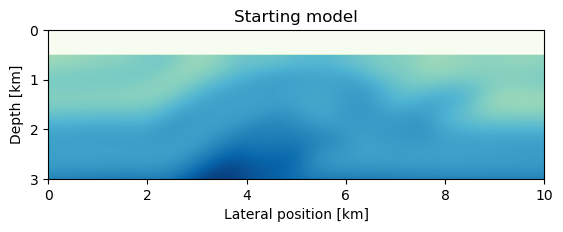

In [28]:
m0, n, d, o = read(h5open("/g/data/up99/sandbox/JUDI/overthrust_model.h5","r"),"m0","n","d","o"); title("Starting model")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0);
imshow(sqrt.(1f0./m0)', cmap="GnBu", extent=(0,10,3,0));
xlabel("Lateral position [km]");
ylabel("Depth [km]");

#### Read SET-Y file containing test data:

In [29]:
block = segy_read("/g/data/up99/sandbox/JUDI/overthrust_shot_records.segy");
d_obs = judiVector(block);

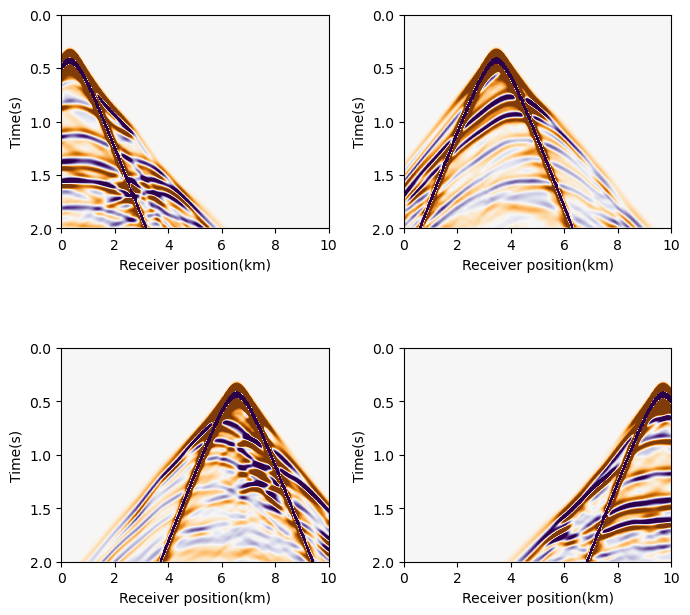

In [30]:
extent = [0, 10, 2, 0]
figure(figsize=(7, 7))
subplot(221)
imshow(d_obs.data[1], vmin=-1, vmax=1, cmap="PuOr", extent=extent, aspect=4, interpolation="hamming")
xlabel("Receiver position(km)")
ylabel("Time(s)")
subplot(222)
imshow(d_obs.data[6], vmin=-1, vmax=1, cmap="PuOr", extent=extent, aspect=4, interpolation="hamming")
xlabel("Receiver position(km)")
ylabel("Time(s)")
subplot(223)
imshow(d_obs.data[11], vmin=-1, vmax=1, cmap="PuOr", extent=extent, aspect=4, interpolation="hamming")
xlabel("Receiver position(km)")
ylabel("Time(s)")
subplot(224)
imshow(d_obs.data[16], vmin=-1, vmax=1, cmap="PuOr", extent=extent, aspect=4, interpolation="hamming")
xlabel("Receiver position(km)")
ylabel("Time(s)")
tight_layout()

#### Create a JUDI geometry structure for the source and set up an 8 Hz Ricker wavelet:

In [31]:
src_geometry = Geometry(block; key="source");
src_data = ricker_wavelet(src_geometry.t[1], src_geometry.dt[1], 0.008f0);
q = judiVector(src_geometry, src_data);

### Optimization using NLopt optimization library:

In [32]:
batchsize = 8;
count = 0;

# NLopt objective function
function objf!(x, grad)
    if count == 0
        @printf("%10s %15s %15s\n","Iteration","Function Val","norm(g)")
    end
    # Update model
    model0.m .= Float32.(reshape(x, model0.n))

    # Seclect batch and calculate gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])

    # Reset gradient in water column to zero
    gradient = reshape(gradient, model0.n)
    gradient[:,1:21] .= 0f0
    if length(grad) > 0
        grad[1:end] = vec(gradient)
    end
    global count += 1
    @printf("%10d %15.5e %15.5e\n",count, fval, norm(g))
    return convert(Float64, fval)
end

objf! (generic function with 1 method)

In [33]:
g = zeros(prod(model0.n))
f0 = objf!(vec(model0.m), g)
# Reset count
global count = 0;

 Iteration    Function Val         norm(g)
         1     2.56147e+05     2.92320e+05


Building forward operator
Operator `forward` ran in 0.30 s
Building adjoint born operator
Operator `gradient` ran in 0.77 s
Operator `forward` ran in 0.56 s
Operator `gradient` ran in 0.77 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.29 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.27 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.27 s


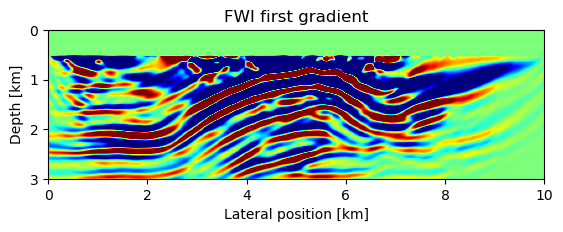

In [34]:
imshow(reshape(g, model0.n)', vmin=-1e3, vmax=1e3, extent=(0,10,3,0), cmap="jet")
title("FWI first gradient")
xlabel("Lateral position [km]");
ylabel("Depth [km]");

In [35]:
# Squared slowness
mmax = (1.3f0).^(-2)
mmin = (6.5f0).^(-2)

opt = Opt(:LD_LBFGS, prod(model0.n))
opt.lower_bounds = mmin
opt.upper_bounds = mmax
# min_objective!(opt, f!)
opt.min_objective = objf!
opt.maxeval = 15

15

In [36]:
@time (minf, minx, ret) = optimize(opt, Vector{Float64}(model0.m))

 Iteration    Function Val         norm(g)
         1     2.61347e+05     2.92320e+05


Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.27 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.27 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.27 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.27 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.27 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.27 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.27 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.27 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.

         2     2.18215e+05     2.92320e+05
         3     1.20635e+05     2.92320e+05


Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.35 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.

         4     1.05556e+05     2.92320e+05
         5     8.19275e+04     2.92320e+05


Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.35 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.36 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.35 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.35 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.35 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.35 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.

         6     6.85917e+04     2.92320e+05
         7     5.18652e+04     2.92320e+05


Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.35 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.35 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.

         8     4.11092e+04     2.92320e+05
         9     3.19265e+04     2.92320e+05


Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.36 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.

        10     2.76046e+04     2.92320e+05
        11     2.33185e+04     2.92320e+05


Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.37 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.35 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.36 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.

        12     2.15285e+04     2.92320e+05
        13     1.74679e+04     2.92320e+05


Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.35 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.35 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.36 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.

        14     1.58095e+04     2.92320e+05
        15     1.33358e+04     2.92320e+05
114.205477 seconds (2.20 M allocations: 1.536 GiB, 0.16% gc time, 0.16% compilation time)


Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.34 s


(13335.802734375, [0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136  …  0.049282442707413596, 0.04935896688971528, 0.04942718378579618, 0.04950369966833905, 0.049605090798109305, 0.049745737461455976, 0.04993673155551936, 0.05018579995786673, 0.05049781131961653, 0.05087537831444908], :MAXEVAL_REACHED)

#### Plot final velocity model after 15 function evaluations:

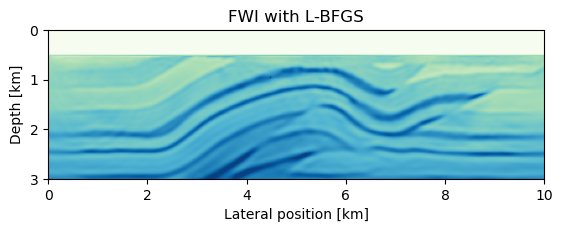

In [37]:
imshow(sqrt.(1f0./reshape(minx, model0.n))', cmap="GnBu", extent=(0,10,3,0), vmin=1.5, vmax=5.4); title("FWI with L-BFGS")
xlabel("Lateral position [km]");
ylabel("Depth [km]");

## Modeling and inversion with JUDI

In [38]:
using JUDI, PyPlot, LinearAlgebra

#### Create a JUDI model structure

In [39]:
# Set up model structure
n = (120, 100)   # (x,y,z) or (x,z)
d = (10., 10.)
o = (0., 0.)

# Velocity [km/s]
v = ones(Float32,n) .+ 0.5f0
v0 = ones(Float32,n) .+ 0.5f0
v[:,Int(round(end/2)):end] .= 3.5f0
rho = (v0 .+ .5f0) ./ 2

# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2
m0 = (1f0 ./ v0).^2
dm = vec(m0 - m)

# Setup model structure
nsrc = 2  # number of sources
model = Model(n, d, o, m)
model0 = Model(n, d, o, m0)

Model (n=(120, 100), d=(10.0f0, 10.0f0), o=(0.0f0, 0.0f0)) with parameters [:m]

#### Create acquisition geometry

In [40]:
# Set up receiver geometry
nxrec = 120
xrec = range(0f0, stop=(n[1]-1)*d[1], length=nxrec)
yrec = 0f0 # WE have to set the y coordiante to zero (or any number) for 2D modeling
zrec = range(d[1], stop=d[1], length=nxrec)

# receiver sampling and recording time
timeD = 1250f0   # receiver recording time [ms]
dtD = 2f0    # receiver sampling interval [ms]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dtD, t=timeD, nsrc=nsrc)

xsrc = convertToCell(range(0f0, stop=(n[1]-1)*d[1], length=nsrc))
ysrc = convertToCell(range(0f0, stop=0f0, length=nsrc))
zsrc = convertToCell(range(d[1], stop=d[1], length=nsrc))

# Set up source structure
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dtD, t=timeD)

GeometryIC{Float32} wiht 2 sources


#### Source judiVector

In [41]:
# setup wavelet
f0 = 0.01f0     # kHz
wavelet = ricker_wavelet(timeD, dtD, f0)
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 2 sources


#### Modeling

In [42]:
# Setup options
opt = Options(subsampling_factor=2, dt_comp=1.0)

JUDIOptions(8, false, false, 1000.0, false, "", "shot", false, false, Any[], "as", 2, 1, false, 1.0, 0.015f0)

In [43]:
# Setup operators
Pr = judiProjection(recGeometry)
F = judiModeling(model; options=opt)
F0 = judiModeling(model0; options=opt)
Ps = judiProjection(srcGeometry)
J = judiJacobian(Pr*F0*adjoint(Ps), q)

JUDI born{Float32} propagator (z * x) -> (src * rec * time)

### Model and image data

In [44]:
# Nonlinear modeling
dobs = Pr*F*adjoint(Ps)*q

Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s


judiVector{Float32, Matrix{Float32}} with 2 sources


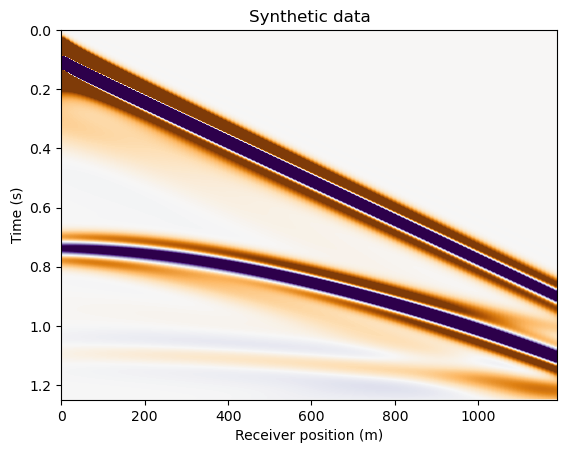

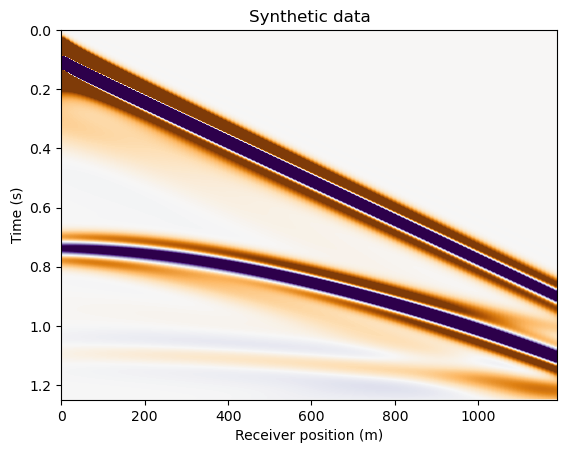

In [45]:
fig = figure()
imshow(dobs.data[1], vmin=-1, vmax=1, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
xlabel("Receiver position (m)")
ylabel("Time (s)")
title("Synthetic data")
display(fig)

In [46]:
# # Adjoint
qad = Ps*adjoint(F)*adjoint(Pr)*dobs

# <x, F'y>
dot1 = dot(q, qad)
# <F x, y>
dot2 = dot(dobs, dobs)
# Compare
@show dot1, dot2, (dot2 - dot2)/(dot1 + dot2)

(dot1, dot2, (dot2 - dot2) / (dot1 + dot2)) = (462909.12f0, 462909.22f0, 0.0f0)


Building forward operator
Operator `adjoint` ran in 0.25 s
Operator `adjoint` ran in 0.25 s


(462909.12f0, 462909.22f0, 0.0f0)

### Inversion

In [47]:
# Linearized modeling J*dm
dD = J*dm
# Adjoint jacobian, RTM image
rtm = adjoint(J)*dD

Building born operator
Operator `born` ran in 0.19 s
Operator `born` ran in 0.19 s
Building forward operator
Operator `forward` ran in 0.22 s
Building adjoint born operator
Operator `gradient` ran in 0.27 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.27 s


PhysicalParameter{Float32} of size (120, 100) with origin (0.0, 0.0) and spacing (10.0, 10.0)


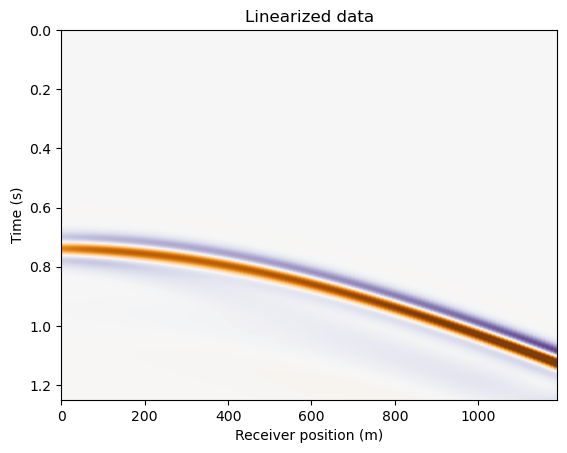

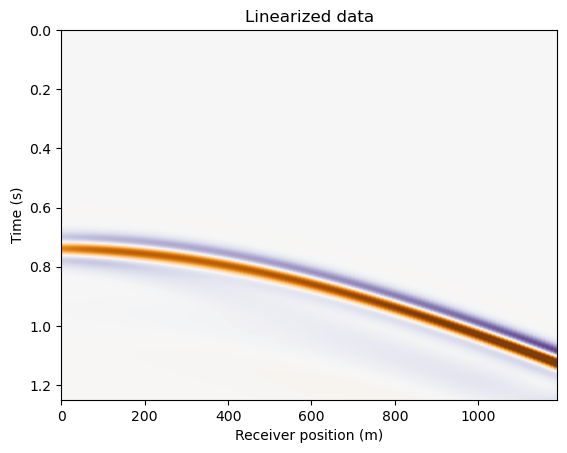

In [48]:
fig = figure()
imshow(dD.data[1], vmin=-1, vmax=1, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
xlabel("Receiver position (m)")
ylabel("Time (s)")
title("Linearized data")
display(fig)

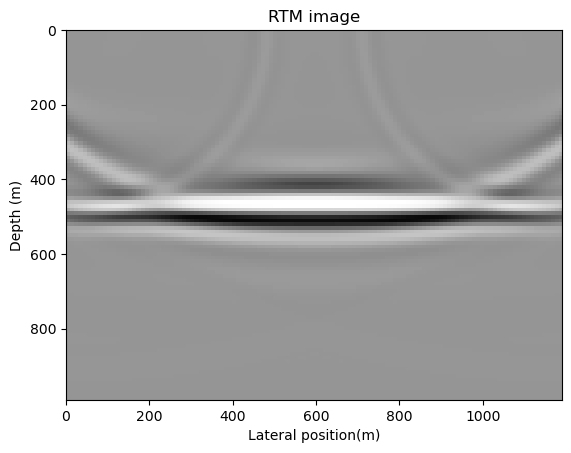

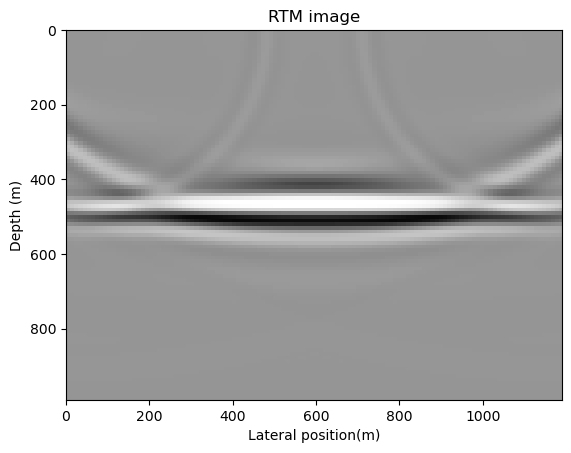

In [49]:
fig = figure()
imshow(rtm', vmin=-1e2, vmax=1e2, cmap="Greys", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0 ], aspect="auto")
xlabel("Lateral position(m)")
ylabel("Depth (m)")
title("RTM image")
display(fig)

#### Inversion utility functions

In [50]:
# evaluate FWI objective function
f, g = fwi_objective(model0, q, dobs; options=opt)

Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.27 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.27 s


(21534.414f0, PhysicalParameter{Float32} of size (120, 100) with origin (0.0f0, 0.0f0) and spacing (10.0f0, 10.0f0))

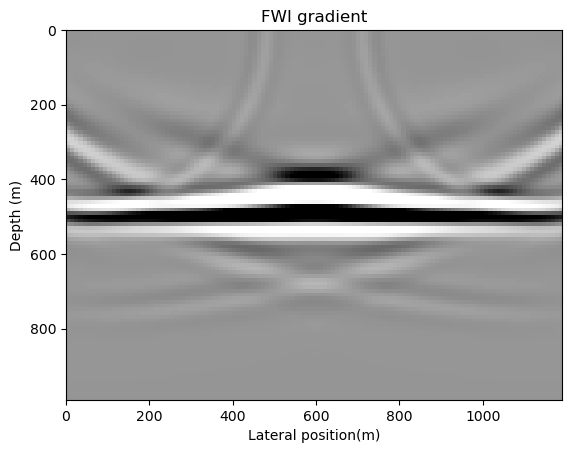

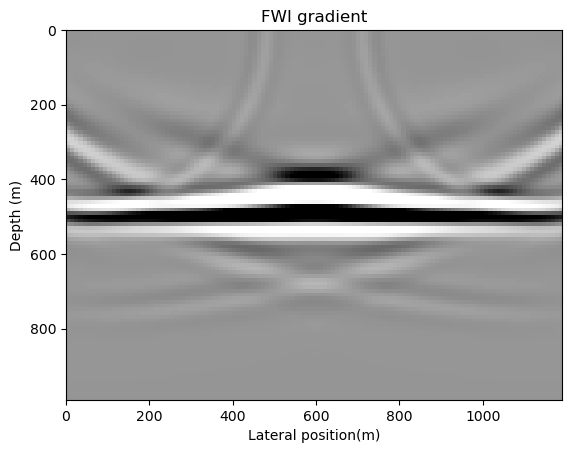

In [51]:
fig = figure()
imshow(g', vmin=-1e2, vmax=1e2, cmap="Greys", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0 ], aspect="auto")
xlabel("Lateral position(m)")
ylabel("Depth (m)")
title("FWI gradient")
display(fig)

In [52]:
# evaluate LSRTM objective function
fj, gj = lsrtm_objective(model0, q, dD, dm; options=opt)
fjn, gjn = lsrtm_objective(model0, q, dobs, dm; nlind=true, options=opt)

Building born operator
Operator `born` ran in 0.20 s
Building adjoint born operator
Operator `gradient` ran in 0.11 s
Operator `born` ran in 0.18 s
Operator `gradient` ran in 0.10 s
Building born operator
Operator `born` ran in 0.52 s
Operator `gradient` ran in 0.26 s
Operator `born` ran in 0.47 s
Operator `gradient` ran in 0.25 s


(35776.562f0, PhysicalParameter{Float32} of size (120, 100) with origin (0.0f0, 0.0f0) and spacing (10.0f0, 10.0f0))

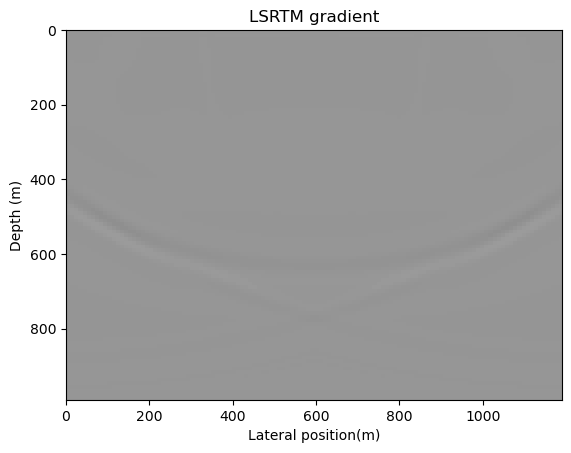

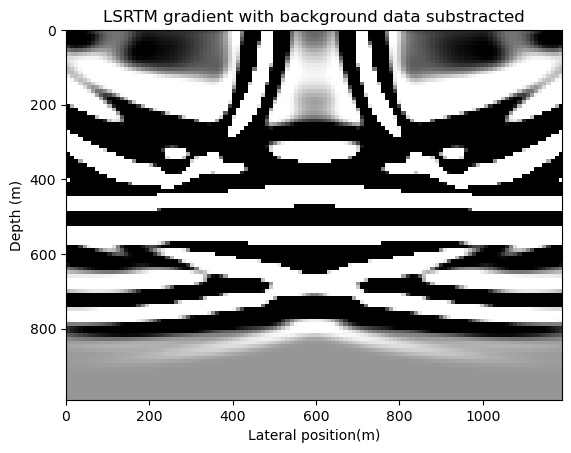

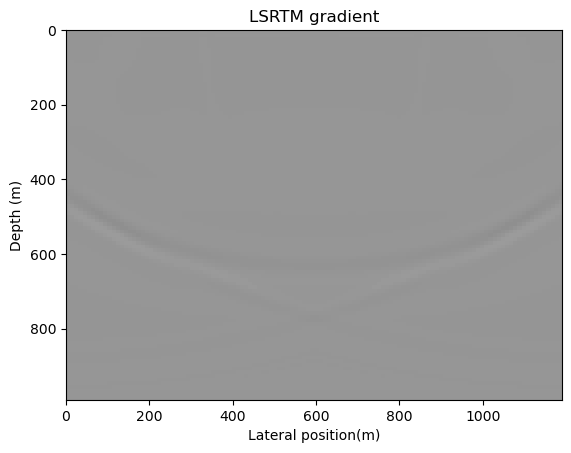

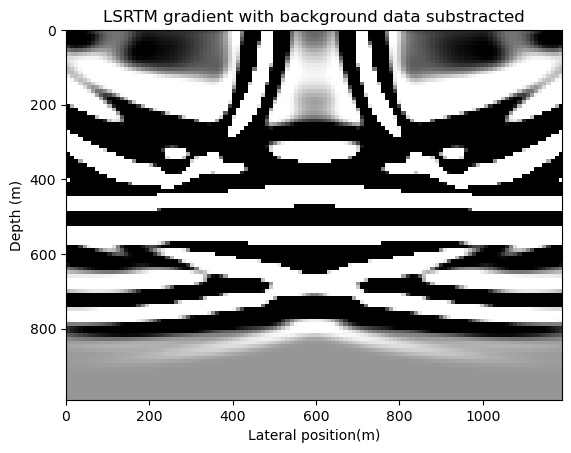

In [53]:
fig = figure()
imshow(gj', vmin=-1, vmax=1, cmap="Greys", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0 ], aspect="auto")
xlabel("Lateral position(m)")
ylabel("Depth (m)")
title("LSRTM gradient")
display(fig)

fig = figure()
imshow(gjn', vmin=-1, vmax=1, cmap="Greys", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0 ], aspect="auto")
xlabel("Lateral position(m)")
ylabel("Depth (m)")
title("LSRTM gradient with background data substracted")
display(fig)

In [54]:
fjn2, gjn2 = lsrtm_objective(model0, q, dobs, 0f0.*dm; nlind=true, options=opt)
fig = figure()

Building born operator
Operator `born` ran in 0.24 s
Operator `gradient` ran in 0.24 s
Operator `born` ran in 0.23 s
Operator `gradient` ran in 0.24 s


Figure(PyObject <Figure size 640x480 with 0 Axes>)

Figure(PyObject <Figure size 640x480 with 0 Axes>)

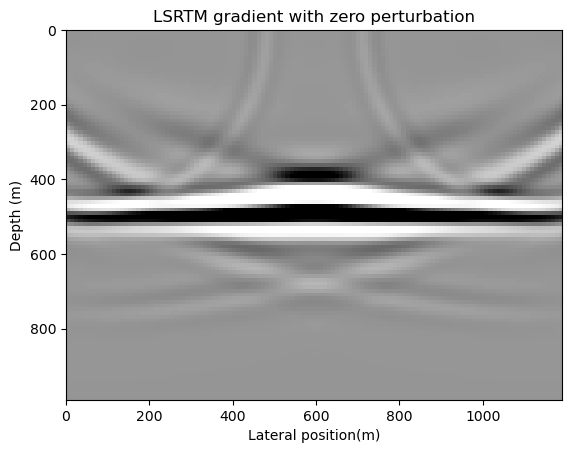

In [55]:
imshow(gjn2', vmin=-1e2, vmax=1e2, cmap="Greys", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0 ], aspect="auto")
xlabel("Lateral position(m)")
ylabel("Depth (m)")
title("LSRTM gradient with zero perturbation")
display(fig)

### TWRI

In [56]:
f, gm, gy = twri_objective(model0, q, dobs, nothing; options=opt, optionswri=TWRIOptions(params=:all))
# With on-the-fly DFT, experimental
f, gmf = twri_objective(model0, q, dobs, nothing; options=Options(frequencies=[[.009, .011], [.008, .012]]), optionswri=TWRIOptions(params=:m))

Operator `forward` ran in 0.19 s
Building forward operator
Operator `adjoint` ran in 0.25 s
Operator `forward_grad` ran in 0.30 s
Operator `forward` ran in 0.21 s
Operator `adjoint` ran in 0.25 s
Operator `forward_grad` ran in 0.30 s
Operator `forward` ran in 0.08 s
Building forward operator
Operator `adjoint` ran in 0.07 s
Operator `forward_grad` ran in 0.17 s
Operator `forward` ran in 0.09 s
Operator `adjoint` ran in 0.16 s
Operator `forward_grad` ran in 0.18 s


(-2326.1504f0, PhysicalParameter{Float32} of size (120, 100) with origin (0.0f0, 0.0f0) and spacing (10.0f0, 10.0f0))

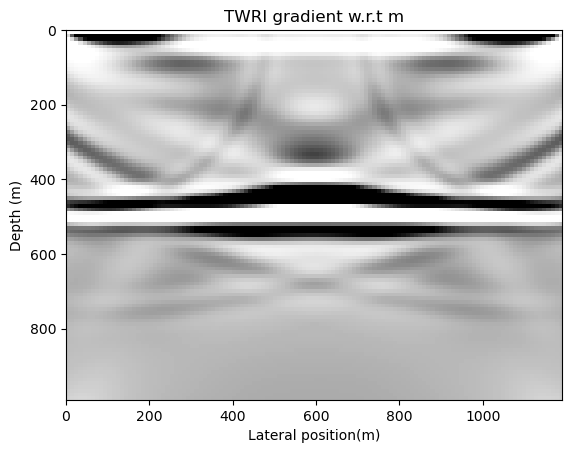

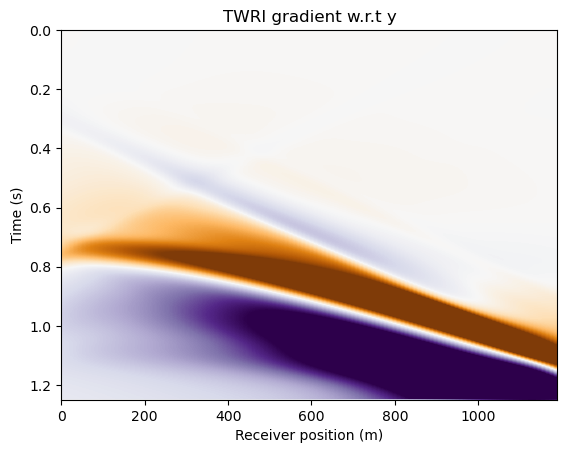

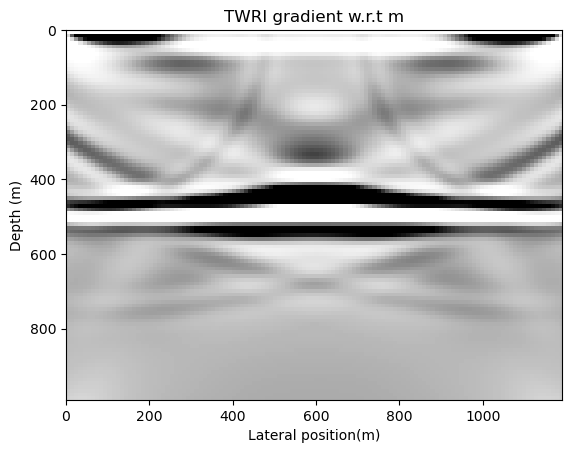

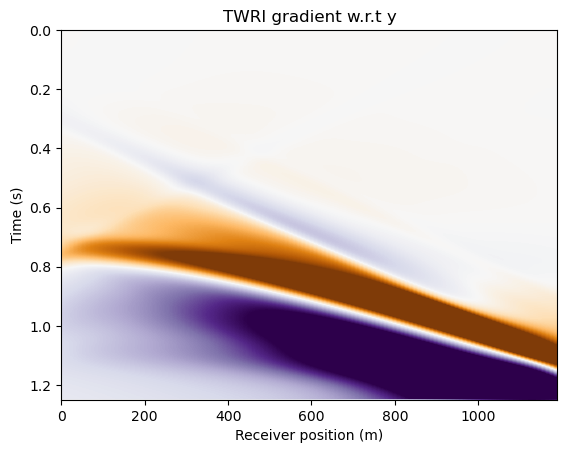

In [57]:
fig = figure()
imshow(gm', vmin=-1, vmax=1, cmap="Greys", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0 ], aspect="auto")
xlabel("Lateral position(m)")
ylabel("Depth (m)")
title("TWRI gradient w.r.t m")
display(fig)

fig = figure()
imshow(gy.data[1], vmin=-1e2, vmax=1e2, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
xlabel("Receiver position (m)")
ylabel("Time (s)")
title("TWRI gradient w.r.t y")
display(fig)

# <font color='Orange'>NearestNeighbors</font>   

In [58]:
using NearestNeighbors
data = rand(3, 10^4)

# Create trees
kdtree = KDTree(data; leafsize = 10)
balltree = BallTree(data, Minkowski(3.5); reorder = false)
brutetree = BruteTree(data)

BruteTree{StaticArraysCore.SVector{3, Float64}, Euclidean}
  Number of points: 10000
  Dimensions: 3
  Metric: Euclidean(0.0)
  Reordered: false

In [59]:
data = rand(3, 10^4)
r = 0.05
point = rand(3)

balltree = BallTree(data)
idxs = inrange(balltree, point, r, true)

2-element Vector{Int64}:
  809
 1165

# <font color='Orange'>Oceananigans</font> 

In [60]:
using Oceananigans

grid = RectilinearGrid(size=(128, 128), x=(0, 2π), y=(0, 2π), topology=(Periodic, Periodic, Flat))
model = NonhydrostaticModel(; grid, advection=WENO5(grid = grid))

ϵ(x, y, z) = 2rand() - 1
set!(model, u=ϵ, v=ϵ)

simulation = Simulation(model; Δt=0.01, stop_iteration=25)
run!(simulation)

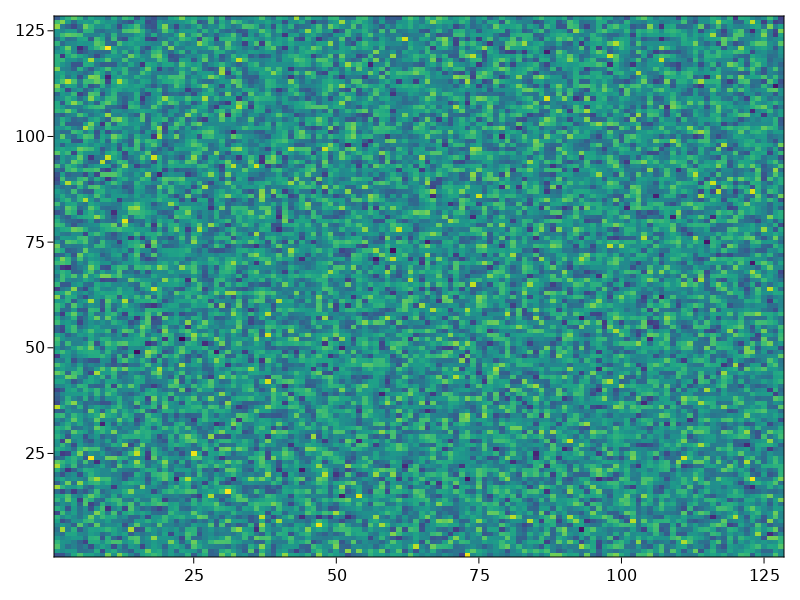

In [61]:
using CairoMakie

u, v, w = model.velocities
ζ = Field(∂x(v) - ∂y(u))
compute!(ζ)

heatmap(interior(ζ, :, :, 1))

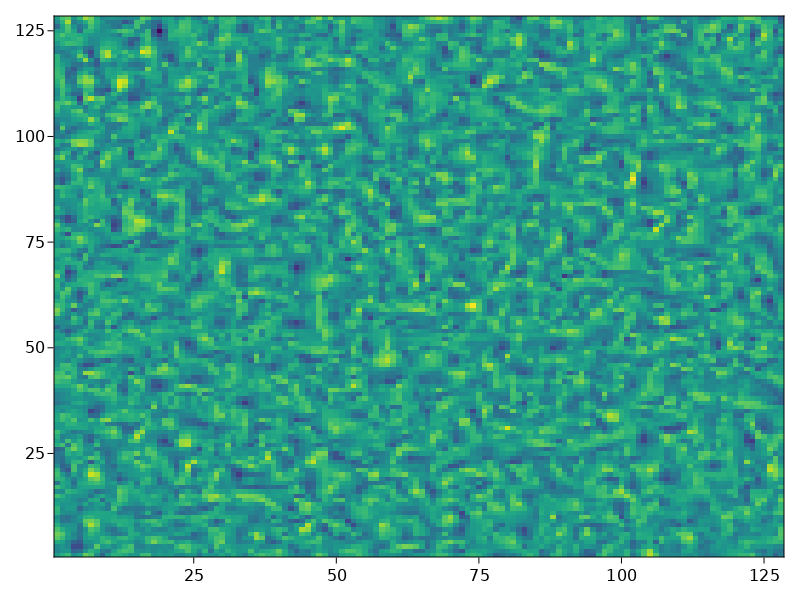

In [62]:
simulation.stop_iteration += 100
run!(simulation)

compute!(ζ)
heatmap(interior(ζ, :, :, 1))

# <font color='Orange'>Plots</font> 

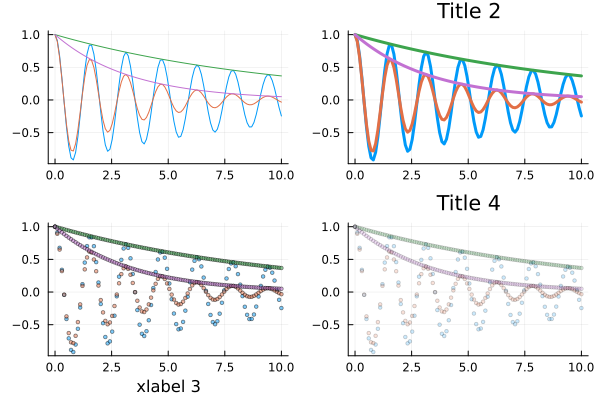

In [63]:
using Plots

x = range(0, 10, length=100)
y1 = @. exp(-0.1x) * cos(4x)
y2 = @. exp(-0.3x) * cos(4x)
y3 = @. exp(-0.1x)
y4 = @. exp(-0.3x)
y = [y1 y2 y3 y4]

p1 = Plots.plot(x, y)
p2 = Plots.plot(x, y, title="Title 2", lw=3)
p3 = Plots.scatter(x, y, ms=2, ma=0.5, xlabel="xlabel 3")
p4 = Plots.scatter(x, y, title="Title 4", ms=2, ma=0.2)
Plots.plot(p1, p2, p3, p4, layout=(2,2), legend=false)

# <font color='Orange'>SeisModels</font> 

In [64]:
using SeisModels

SeisModels.vp(PREM, 3500)

13.711716551639793

In [65]:
parameters = (:vp, :vs, :density);

SeisModels.evaluate.(AK135, parameters, 3680)

(13.591187999999999, 7.226264, 5.4003499999999995)

In [66]:
m = LinearLayeredModel(r=[0, 0.3, 0.3, 1], vp=[1, 1, 1.8, 1], vs=[0, 0, 1, 0.7])

LinearLayeredModel(1.0, 4, [0.0, 0.3, 0.3, 1.0], [1.0, 1.0, 1.8, 1.0], [0.0, 0.0, 1.0, 0.7], Float64[], false, Float64[], Float64[], Float64[], Float64[], Float64[], false, Float64[], Float64[])

In [67]:
radii = [500]

vps =   reshape( # Ensure we have a matrix with 1 column and 4 rows
               [3       # x^0 coefficients in km/s
                0       # x^1
               -2       # x^2
               -1],     # x^3
                :, 1)


α = 1.7

vss = vps./α

m = PREMPolyModel(r=radii, vp=vps, vs=vss)

PREMPolyModel(500.0, 1, [500.0], [3.0; 0.0; -2.0; -1.0;;], [1.7647058823529411; 0.0; -1.1764705882352942; -0.5882352941176471;;], Matrix{Float64}(undef, 0, 0), false, Matrix{Float64}(undef, 0, 0), Matrix{Float64}(undef, 0, 0), Matrix{Float64}(undef, 0, 0), Matrix{Float64}(undef, 0, 0), Matrix{Float64}(undef, 0, 0), false, Matrix{Float64}(undef, 0, 0), Matrix{Float64}(undef, 0, 0), NaN)

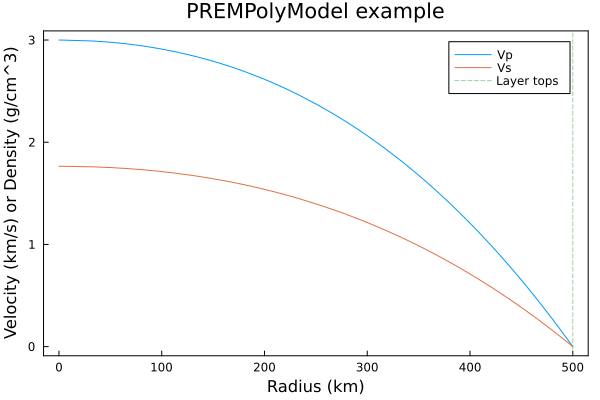

In [68]:
using Plots: plot, plot!, vline!


p = Plots.plot(xlabel="Radius (km)", ylabel="Velocity (km/s) or Density (g/cm^3)", title="PREMPolyModel example", framestyle=:box, grid=false)

for (f, name) in zip((SeisModels.vp, SeisModels.vs), ("Vp", "Vs"))
        Plots.plot!(p, r->f(m, r), 0, surface_radius(m), label=name)
end

Plots.vline!(p, m.r, line=(0.5,:dash), label="Layer tops")